In [5]:
import pandas as pd
import numpy as np
import random
from catboost import CatBoostRegressor

# Глобальная фиксация для всех библиотек
SEED = 322
random.seed(SEED)
np.random.seed(SEED)

def calculate_iou(lower_true, upper_true, lower_pred, upper_pred, epsilon=1e-6):
    intersection = np.maximum(0, np.minimum(upper_true, upper_pred) - np.maximum(lower_true, lower_pred))
    union = (upper_true - lower_true + epsilon) + (upper_pred - lower_pred + epsilon) - intersection
    return np.mean(intersection / union)

# 1. ЗАГРУЗКА
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train[train['price_p05'] > 0]
train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

# 2. FEATURE ENGINEERING
def create_smart_features(df, train_ref=None):
    if train_ref is not None:
        # Средние цены
        prod_price_map = train_ref.groupby('product_id')['price_p05'].mean().to_dict()
        df['global_prod_avg'] = df['product_id'].map(prod_price_map)
        
        cat_price_map = train_ref.groupby('third_category_id')['price_p05'].mean().to_dict()
        df['global_cat_avg'] = df['third_category_id'].map(cat_price_map)
        
        # СТАНДАРТНЫЕ ОТКЛОНЕНИЯ (только по нужным разрезам)
        for col in ['management_group_id', 'first_category_id', 'third_category_id']:
            df[f'std_p05_{col}'] = df[col].map(train_ref.groupby(col)['price_p05'].std().to_dict())
            df[f'std_p95_{col}'] = df[col].map(train_ref.groupby(col)['price_p95'].std().to_dict())
            
    # Технические признаки
    cat_stores_map = df.groupby('third_category_id')['n_stores'].transform('mean')
    df['store_density_ratio'] = df['n_stores'] / (cat_stores_map + 1e-6)
    df['temp_hum_index'] = df['avg_temperature'] * (df['avg_humidity'] / 100)
    df['category_breadth'] = df.groupby(['dt', 'third_category_id'])['product_id'].transform('nunique')
    
    return df

train = create_smart_features(train, train_ref=train)
test = create_smart_features(test, train_ref=train)

# 3. ЦИКЛИЧЕСКИЕ ПРИЗНАКИ (Оставляем только месяц)
def add_cyclical_features(df):
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

train = add_cyclical_features(train)
test = add_cyclical_features(test)

# 4. СПИСОК ПРИЗНАКОВ (Очищенный)
cat_features = ['management_group_id', 'first_category_id', 'activity_flag']

features = [
    'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 
    'avg_wind_level', 'week_of_year', 'month_sin', 'month_cos',
    'global_prod_avg', 'global_cat_avg', 'store_density_ratio',
    'temp_hum_index', 'category_breadth'
] 

# Добавляем только разрешенные std признаки
std_cols = [c for c in train.columns if 'std_p' in c and 'dow' not in c and 'second' not in c]
features += std_cols + cat_features

# Заполнение пропусков
train[features] = train[features].fillna(train[features].mean(numeric_only=True))
test[features] = test[features].fillna(train[features].mean(numeric_only=True))

# 5. ВАЛИДАЦИЯ / КАЛИБРОВКА
train_parts, val_parts = [], []
for _, group in train.groupby('dt'):
    group = group.sample(frac=1, random_state=SEED).reset_index(drop=True)
    split_idx = int(len(group) * 0.8)
    train_parts.append(group.iloc[:split_idx])
    val_parts.append(group.iloc[split_idx:])

train_part = pd.concat(train_parts)
val_part = pd.concat(val_parts)

# ПАРАМЕТРЫ CatBoost
best_optuna_params = {
    'learning_rate': 0.09981859399773757, 
    'depth': 7, 
    'l2_leaf_reg': 8.533654459953857, 
    'random_strength': 1.3535330397123693, 
    'bagging_temperature': 0.757231412091197
}

cb_params = {
    'iterations': 3000,
    'random_seed': SEED,
    'verbose': 100,
    'early_stopping_rounds': 300,
    **best_optuna_params
}

print("Обучение моделей...")
model_low = CatBoostRegressor(loss_function='MAE', **cb_params)
model_high = CatBoostRegressor(loss_function='MAE', **cb_params)

model_low.fit(train_part[features], train_part['price_p05'], 
              eval_set=(val_part[features], val_part['price_p05']), 
              cat_features=cat_features, use_best_model=True)

model_high.fit(train_part[features], train_part['price_p95'], 
               eval_set=(val_part[features], val_part['price_p95']), 
               cat_features=cat_features, use_best_model=True)

# --- РАЗДЕЛЬНЫЙ ПОИСК ALPHA ---
print("\nПоиск оптимальных раздельных alpha...")
calib_preds_low = model_low.predict(val_part[features])
calib_preds_high = model_high.predict(val_part[features])

nonconf_low = calib_preds_low - val_part['price_p05']
nonconf_high = val_part['price_p95'] - calib_preds_high

best_iou = -1
best_alphas = (0.1, 0.1)
best_q = (0, 0)

alphas_to_test = np.linspace(0.1, 0.9, 81)

for al in alphas_to_test:
    ql = np.quantile(nonconf_low, 1 - al/2)
    p05_corr = calib_preds_low - ql
    for ah in alphas_to_test:
        qh = np.quantile(nonconf_high, 1 - ah/2)
        p95_corr = calib_preds_high + qh
        p95_corr_safe = np.maximum(p95_corr, p05_corr + 0.001)
        
        score = calculate_iou(val_part['price_p05'].values, val_part['price_p95'].values, p05_corr, p95_corr_safe)
        if score > best_iou:
            best_iou = score
            best_alphas = (al, ah)
            best_q = (ql, qh)

q_low, q_high = best_q
print(f"Результат: Low Alpha={best_alphas[0]:.3f}, High Alpha={best_alphas[1]:.3f}, IoU={best_iou:.4f}")

# 6. ФИНАЛЬНОЕ ОБУЧЕНИЕ
final_params_low = cb_params.copy()
final_params_low['iterations'] = model_low.get_best_iteration() + 1
final_params_low.pop('early_stopping_rounds', None)

final_params_high = cb_params.copy()
final_params_high['iterations'] = model_high.get_best_iteration() + 1
final_params_high.pop('early_stopping_rounds', None)

final_low = CatBoostRegressor(loss_function='MAE', allow_writing_files=False, **final_params_low)
final_high = CatBoostRegressor(loss_function='MAE', allow_writing_files=False, **final_params_high)

final_low.fit(train[features], train['price_p05'], cat_features=cat_features, verbose=100)
final_high.fit(train[features], train['price_p95'], cat_features=cat_features, verbose=100)

# 7. ПРЕДСКАЗАНИЕ
test['price_p05'] = final_low.predict(test[features]) - q_low
test['price_p95'] = final_high.predict(test[features]) + q_high
test['price_p95'] = np.maximum(test['price_p95'], test['price_p05'] + 0.001)

submission = test[['row_id', 'price_p05', 'price_p95']].sort_values('row_id')
submission.to_csv('submission_v4_clean.csv', index=False)

Обучение моделей...
0:	learn: 0.1427131	test: 0.1345624	best: 0.1345624 (0)	total: 30.5ms	remaining: 1m 31s
100:	learn: 0.0852656	test: 0.0929690	best: 0.0928660 (59)	total: 2.91s	remaining: 1m 23s
200:	learn: 0.0810195	test: 0.0929245	best: 0.0928519 (128)	total: 5.53s	remaining: 1m 16s
300:	learn: 0.0783731	test: 0.0931595	best: 0.0928519 (128)	total: 8.26s	remaining: 1m 14s
400:	learn: 0.0763747	test: 0.0938117	best: 0.0928519 (128)	total: 10.9s	remaining: 1m 10s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.09285187069
bestIteration = 128

Shrink model to first 129 iterations.
0:	learn: 0.0990166	test: 0.0931148	best: 0.0931148 (0)	total: 25ms	remaining: 1m 15s
100:	learn: 0.0812475	test: 0.0881139	best: 0.0878609 (58)	total: 2.63s	remaining: 1m 15s
200:	learn: 0.0763217	test: 0.0886596	best: 0.0878609 (58)	total: 5.45s	remaining: 1m 15s
300:	learn: 0.0736629	test: 0.0893230	best: 0.0878609 (58)	total: 8.27s	remaining: 1m 14s
Stopped by overfitting detector  

In [2]:
# идеи - признаки через стандартные отклонения и т д в разных разрезах?
# анализ текущих ошибок модели на валидации
# замена валидации на OOT ?
# обучение нейросети + conformal + кастомный лосс Pinball + coverage penalty для нейросети 

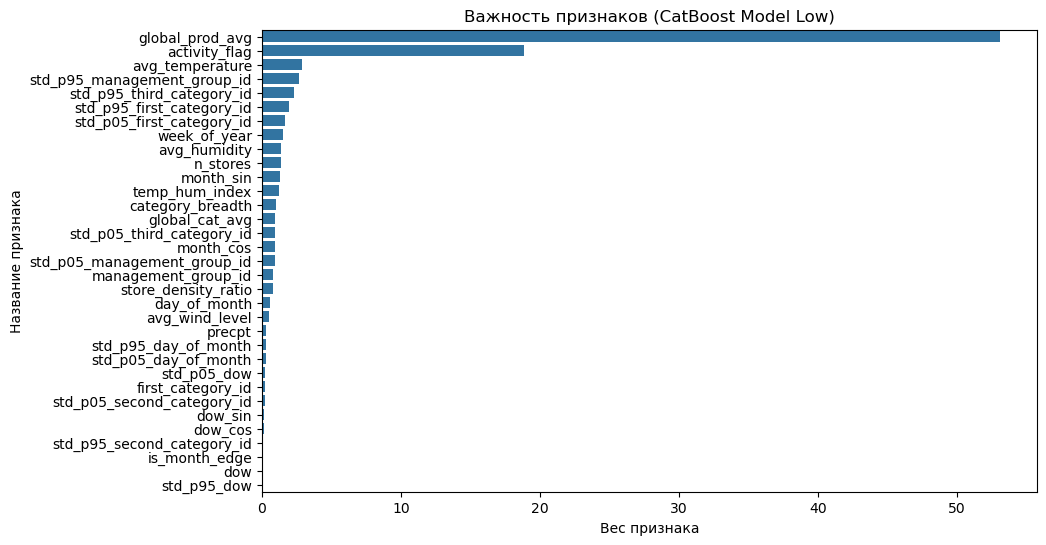

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем данные
feature_importance = final_low.get_feature_importance(prettified=True)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('Важность признаков (CatBoost Model Low)')
plt.xlabel('Вес признака')
plt.ylabel('Название признака')
plt.show()

In [4]:
train.columns

Index(['dt', 'price_p05', 'price_p95', 'n_stores', 'precpt', 'avg_temperature',
       'avg_humidity', 'avg_wind_level', 'holiday_flag', 'activity_flag',
       'management_group_id', 'first_category_id', 'second_category_id',
       'third_category_id', 'dow', 'day_of_month', 'week_of_year', 'month',
       'product_id', 'is_month_edge', 'global_prod_avg', 'global_cat_avg',
       'std_p05_management_group_id', 'std_p95_management_group_id',
       'std_p05_first_category_id', 'std_p95_first_category_id',
       'std_p05_second_category_id', 'std_p95_second_category_id',
       'std_p05_third_category_id', 'std_p95_third_category_id', 'std_p05_dow',
       'std_p95_dow', 'std_p05_day_of_month', 'std_p95_day_of_month',
       'store_density_ratio', 'temp_hum_index', 'category_breadth', 'dow_sin',
       'dow_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [ ]:
std_p95_dow
dow
is_month_edge
std p95 second category id
dow cos
dow sin